# MNIST memory analysis

## Init

### Setting up vlog-enabled TensorFlow

In [1]:
# Tools for parsing memory allocation/deallocation logs out of
# VLOG
#
# This needs
# memory loging turned on as in
# https://github.com/yaroslavvb/tensorflow/tree/memory_logging
# ie
# define VLOG_IS_ON(lvl) ((lvl) <= 1) in platform/default/logging.h
# and
# LOG(INFO) << LogMemory::kLogMemoryLabel << " " << type_name << " { "
# -            << ProtoShortDebugString(proto) << " }";
# +  << ProtoShortDebugString(proto) << " } timestamp " << CurrentThreadTimeNanos();
# in tensorflow/core/framework/log_memory.cc
#
# Pre-built version
# https://www.dropbox.com/s/pyu92nj4oifw6cg/tensorflow-0.12.0rc0-cp35-cp35m-linux_x86_64.whl?dl=0

### Common imports

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import re, os, sys
tf.__version__

'0.12.0-rc1'

### LOG_MEMORY parsing

In [48]:
# Setup utilities to parse __LOG_MEMORY__ statements in command-line
tensor_allocation_regex = re.compile(r"allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")   
tensor_deallocation_regex = re.compile(r"allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")

def _parse_logline(l):
    # There are 4 kinds of lines with __LOG_MEMORY__ tag
    # MemoryLogTensorDeallocation, MemoryLogTensorAllocation, MemoryLogStep,
    #
    # Example lines for debugging:
    # MemoryLogTensorDeallocation
    # 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cpu" } timestamp 5143420588459765

    # MemoryLogTensorAllocation
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 has_single_reference: true ptr: 29496256 } } } timestamp 5143420588526034

    # MemoryLogStep
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 1 handle: "->Print:0//0/;0" } timestamp 5143420588718348

    # MemoryLogTensorOutput
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Const" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 ptr: 29496256 } } } timestamp 5143420588932740
     
    if 'MemoryLogTensorOutput' in l:
        m = tensor_output_regex.search(l)
        # assert m, l
        if not m:  # some Shape lines are missing bytes info, ie
            # I 5162643141.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 5 kernel_name: "gradients/Shape" tensor { dtype: DT_INT32 shape { dim { } } } } timestamp 5162643141310124
            return {}
        d = {f: m.group(f) for f in ["timestamp", "allocation_id",
                                     "allocated_bytes", "kernel_name"]}
        d["timestamp"] = int(d["timestamp"])
        d["allocation_id"] = int(d["allocation_id"])
        d["allocated_bytes"] = int(d["allocated_bytes"])
    elif 'MemoryLogTensorAllocation' in l:
        m = tensor_allocation_regex.search(l)
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id",
                                          "allocated_bytes"]}
        d["kernel_name"] = "<unknown>"
    elif 'MemoryLogTensorDeallocation' in l:
        m = tensor_deallocation_regex.search(l)
        assert m, l
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id"]}
    else:
        d = {}
    return d

def memory_timeline(output):
    """Returns array of tuples representing memory actions
    (timestamp_nanoseconds, kernel_name, memory_bytes)
    memory is positive for allocations and negative for deallocations.
    timestamps are relative to the first memory allocation line found
    """
    
    parsed_lines = [_parse_logline(l) for l in output.split("\n")]
    parsed_lines = [l for l in parsed_lines if l] # remove Nones
    parsed_lines.sort(key=lambda l: l["timestamp"])
    first_timestamp = parsed_lines[0]["timestamp"]
    
    # Tensors that are output have two records (allocation and output)
    # since output comes after, overwrite allocation_map with output
    # info (it has kernel_name)
    allocation_map = {} # map of allocation_id->parsed_logline of allocation
    double_records = {} # map of ids which have both allocation and output
    for line in parsed_lines:
        if "kernel_name" in line:
            if line["allocation_id"] in allocation_map:
                double_records[line["allocation_id"]] = True
            line["allocation_id"]
            allocation_map[line["allocation_id"]] = line
            

    result = []
    for line in parsed_lines:
        if "kernel_name" in line:
            # ignore tensorallocation lines which will later have tensoroutput
            if (line["allocation_id"] in double_records and
                line["kernel_name"] == "<unknown>"):
                continue
            kernel_name = line["kernel_name"]
            allocated_bytes = line["allocated_bytes"]
        else: # deallocation
            allocation_line = allocation_map[line["allocation_id"]]
            kernel_name = allocation_line["kernel_name"]
            allocated_bytes = -allocation_line["allocated_bytes"]
        result.append((line["timestamp"]-first_timestamp, kernel_name,
                       allocated_bytes))
    return result


def print_memory_timeline(stderr):
    total_memory = 0
    for record in memory_timeline(stderr):
        timestamp, kernel_name, allocated_bytes = record
        if abs(allocated_bytes)<1000:
            continue  # ignore small allocations
        total_memory += allocated_bytes
        print("%9d %40s %11d %11d"%(timestamp, kernel_name, allocated_bytes, total_memory))

def plot_memory_timeline(stderr):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += record[-1]
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)
    
    
run_metadata = tf.RunMetadata()
def summarize(run_metadata=run_metadata):
    ss = tf.contrib.stat_summarizer.NewStatSummarizer(tf.get_default_graph().as_graph_def().SerializeToString())
    ss.ProcessStepStatsStr(run_metadata.step_stats.SerializeToString())
    print(ss.GetOutputString())
    
def create_session():
    config = tf.ConfigProto(graph_options=tf.GraphOptions(
        optimizer_options=tf.OptimizerOptions(
            opt_level=tf.OptimizerOptions.L0)))
    return tf.Session(config=config)

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
def sessrun(*args, **kwargs):
    sess = create_session()
    sess.run(tf.global_variables_initializer())
    kwargs["run_metadata"] = run_metadata
    kwargs["options"] = run_options
    return sess.run(*args, **kwargs)

import tensorflow.contrib.graph_editor as ge
def run_after(a_tensor, b_tensor):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a_tensor.op, [b_tensor.op])
    

### Output Redirector

Utility to capture stderr into string. Hangs if pipe buffer is exceeded (65k). For larger outputs use <tags> as below and launch jupyter with file redirect: jupyter notebook &> /tmp/jupyter.txt

In [6]:
import os
import sys

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output

redirect=FDRedirector(STDERR)
stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect.start();
    yield
    stderr = redirect.stop()

## Memory timeline on simple graph

In [7]:
n=1000*1000*25
tf.reset_default_graph()
a1 = tf.random_uniform(shape=(n,), name="a1")
a2 = tf.mul(a1, 2., name="a2")
a3 = tf.mul(a2, 2., name="a3")
a4 = tf.mul(a3, 2., name="a4")
c = tf.mul(a4, 3., name="cost")
b4 = tf.add(c, a4, name="b4")
b3 = tf.add(b4, a3, name="b3")
b2 = tf.add(b3, a2, name="b2")
b1 = tf.add(b2, a1, name="b1")

sess = tf.Session()
with grab_stderr():
    sess.run(b1)

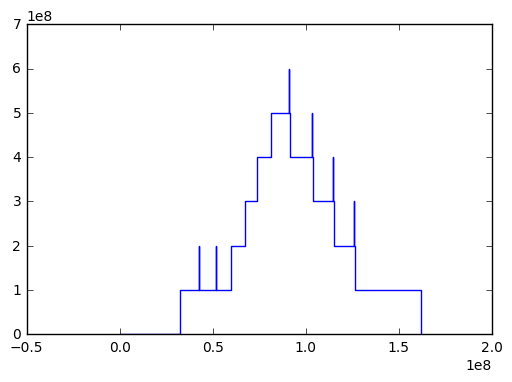

In [8]:
plot_memory_timeline(stderr)

In [12]:
print_memory_timeline(stderr)

 30592933               a1/RandomUniform  100000000  100000000
 40843841                         a1/mul  100000000  200000000
 40932787               a1/RandomUniform -100000000  100000000
 49626711                             a1  100000000  200000000
 49735494                         a1/mul -100000000  100000000
 58361205                             a2  100000000  200000000
 66034373                             a3  100000000  300000000
 73218022                             a4  100000000  400000000
 81991267                           cost  100000000  500000000
 92463254                             b4  100000000  600000000
 92560705                           cost -100000000  500000000
 92900165                             a4 -100000000  400000000
103306026                             b3  100000000  500000000
103411549                             b4 -100000000  400000000
103873232                             a3 -100000000  300000000
116717493                             b2  100000000  40

## Memory timeline for MNIST graph

In [39]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

tf.reset_default_graph()
 
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()
 
x = tf.placeholder(tf.float32, shape=[None, 784], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y")
 
def weight_variable(shape, name=""):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name=name)
 
def bias_variable(shape, name=""):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name=name)
 
def conv2d(x, W, name=""):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)
 
def max_pool_2x2(x, name=""):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)
 
 
W_conv1 = weight_variable([5, 5, 1, 32], name="W1")
b_conv1 = bias_variable([32], name="b1")
 
x_image = tf.reshape(x, [-1,28,28,1])
 
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, name="h_conv1") + b_conv1, name="h_conv1_relu")
h_pool1 = max_pool_2x2(h_conv1, name="h_pool1")
 
W_conv2 = weight_variable([5, 5, 32, 64], name="W_conv2")
b_conv2 = bias_variable([64], name="b_conv2")
 
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, name="h_conv2") + b_conv2, name="h_conv2_relu")
h_pool2 = max_pool_2x2(h_conv2, name="h_pool2")
 
W_fc1 = weight_variable([7 * 7 * 64, 1024], name="W_fc1")
b_fc1 = bias_variable([1024], name="b_fc1")
 
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name="h_pool2_flat")
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name="h_fc1")
 
keep_prob = tf.placeholder(tf.float32, name="keep_prob")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name="h_fc1_drop")
 
W_fc2 = weight_variable([1024, 10], name="W_fc2")
b_fc2 = bias_variable([10], name="b_fc2")
 
matmul2 = tf.matmul(h_fc1_drop, W_fc2, name="matmul2")
y_conv = tf.add(matmul2, b_fc2, name="y_conv")
 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_), name="cross_entropy")
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Memory timeline for eval step

In [40]:
def open_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<BEGIN>"))
    
def close_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<END>"))
    
def grab_output(tag, filename="/tmp/jupyter.txt"):
    s = open(filename).read()
    opening_tag = tag+"<BEGIN>"
    ending_tag = tag+"<END>"
    starting_pos = s.rfind(opening_tag)
    ending_pos = s.rfind(ending_tag)
    return s[starting_pos:ending_pos]

In [50]:
n = 1000
open_tag('mnist')
sess.run(accuracy.op, feed_dict={ x:mnist.train.images[:n], y_: mnist.train.labels[:n], keep_prob: 1.0})
close_tag('mnist')
output = grab_output('mnist')

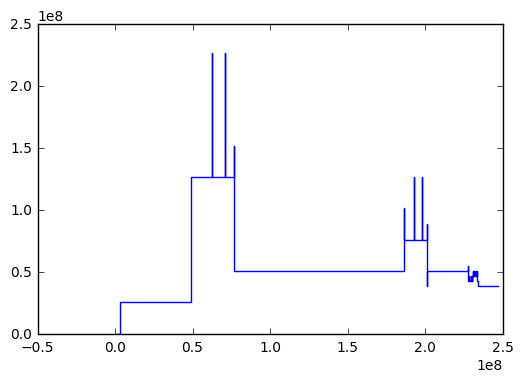

In [51]:
plot_memory_timeline(output)

In [52]:
print_memory_timeline(output)

  2940766                                       W1        3200        3200
  2960737                                    W_fc1    12845056    12848256
  3008672                                  W_conv2      204800    13053056
  3070758                                    b_fc1        4096    13057152
  3086434                                    W_fc2       40960    13098112
  3200656                                  W1/read        3200    13101312
  3265057                             W_conv2/read      204800    13306112
  3375293                               W_fc2/read       40960    13347072
  3479547                               W_fc1/read    12845056    26192128
  3517752                               b_fc1/read        4096    26196224
  4243287                                 ArgMax_1        8000    26204224
 49315014                                  h_conv1   100352000   126556224
 62631584                                      add   100352000   226908224
 62726271                

In [19]:
sessrun(accuracy.op, feed_dict={ x:mnist.train.images[:1000], y_: mnist.train.labels[:1000], keep_prob: 1.0})

In [20]:
summarize()

Total time (us): curr=215701 count=11 runs, avg 215.7 ms, 368 nodes defined 53 nodes observed
530277.02 avg KB per run.

============ By run order (ms) =================
  [start]  [first]    [avg]	     [%] 	  [cdf%] 	      [Op]	[Name]
    0.000    0.058    0.058	  0.027%	  0.027%	          	_SOURCE
    0.157    0.335    0.335	  0.155%	  0.182%	  Variable	Variable
    0.167    0.809    0.809	  0.375%	  0.557%	     Const	Reshape/shape
    0.168    0.511    0.511	  0.237%	  0.794%	  Variable	Variable_2
    0.168    0.498    0.498	  0.231%	  1.025%	  Variable	Variable_1
    0.169    0.143    0.143	  0.066%	  1.091%	  Variable	Variable_3
    0.185    0.439    0.439	  0.204%	  1.295%	  Variable	Variable_4
    0.200    0.545    0.545	  0.253%	  1.548%	  Variable	Variable_5
    0.203    0.444    0.444	  0.206%	  1.753%	  Variable	Variable_6
    0.211    0.133    0.133	  0.062%	  1.815%	  Variable	Variable_7
    0.361    0.274    0.274	  0.127%	  1.942%	  Identity	Variable_7/read
    0.507    

In [22]:
mnist.train.images[0].shape

(784,)

In [23]:
784*1000

784000

In [53]:
h_conv1.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28), Dimension(32)])

In [55]:
1000*28*28*32*4

100352000